In [1]:
import pandas as pd
import matplotlib.pyplot as plt

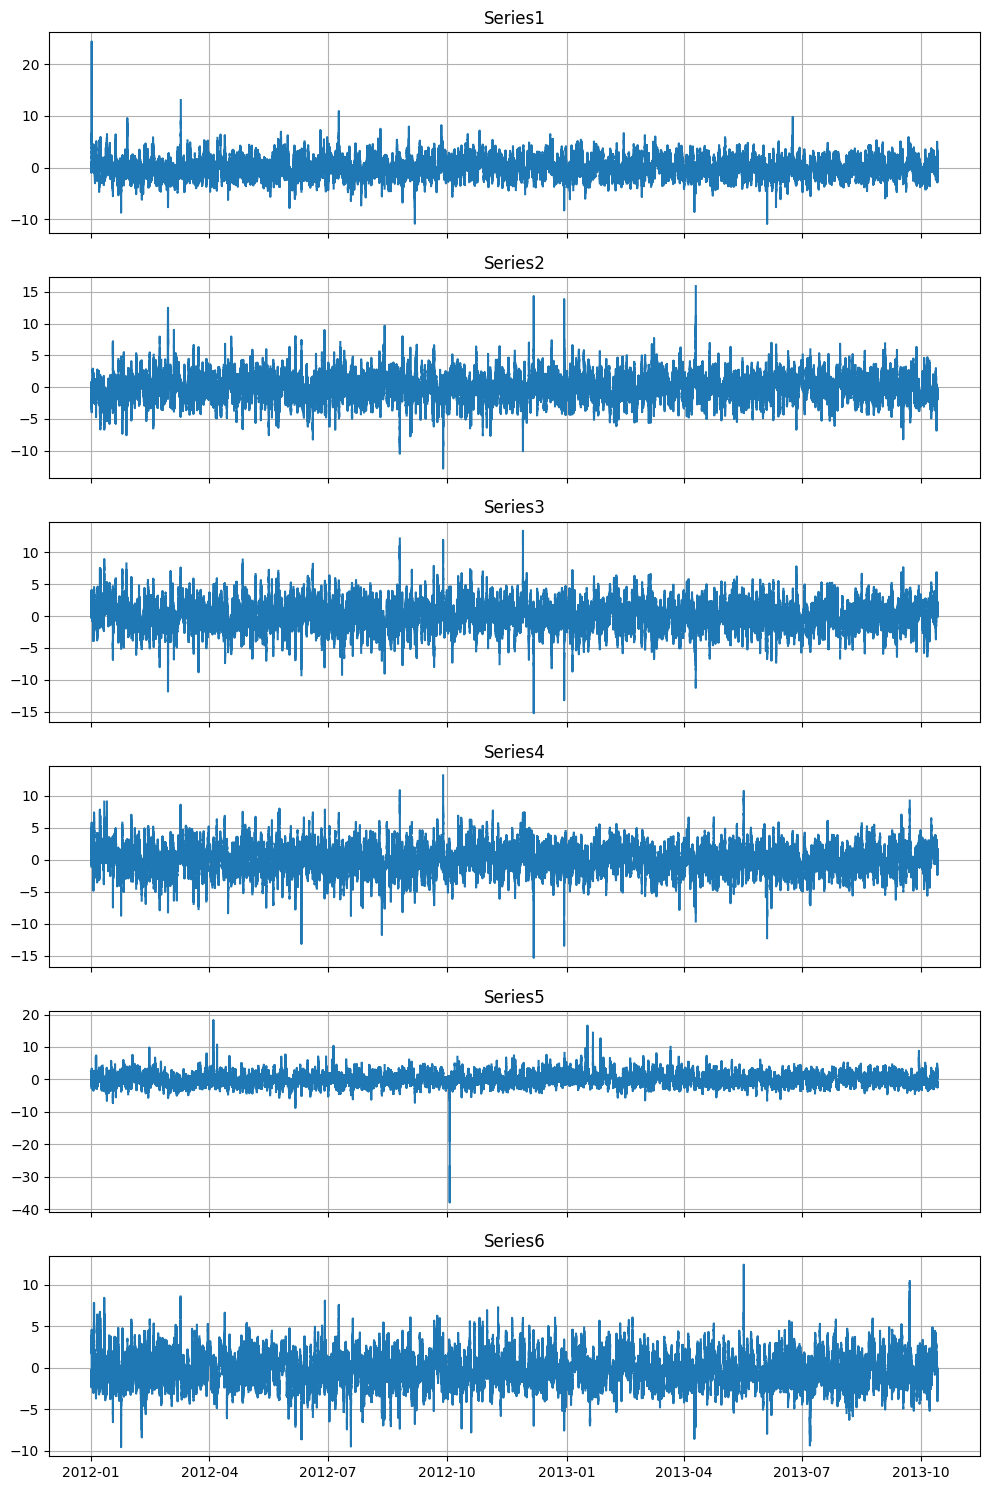

In [2]:
df = pd.read_csv('../data/raw/train_set.csv', index_col=0, parse_dates=True)

# Create a subplot for each column
fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, 2.5 * len(df.columns)), sharex=True)

# If only one column, axes is not iterable — fix that:
if len(df.columns) == 1:
    axes = [axes]

# Plot each column
for i, column in enumerate(df.columns):
    axes[i].plot(df.index, df[column])
    axes[i].set_title(column)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Column: Series1
Outliers removed: 3294
Missing values filled: 49383


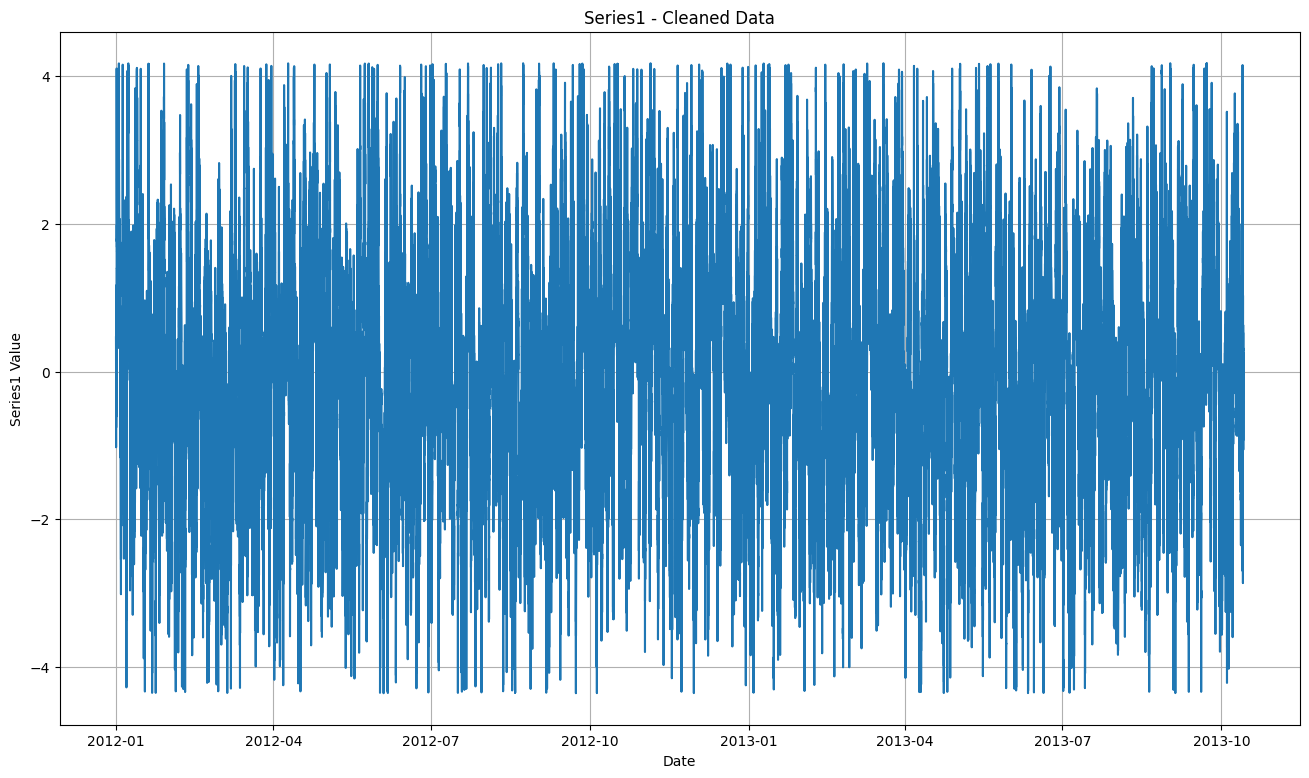

Column: Series2
Outliers removed: 7011
Missing values filled: 52544


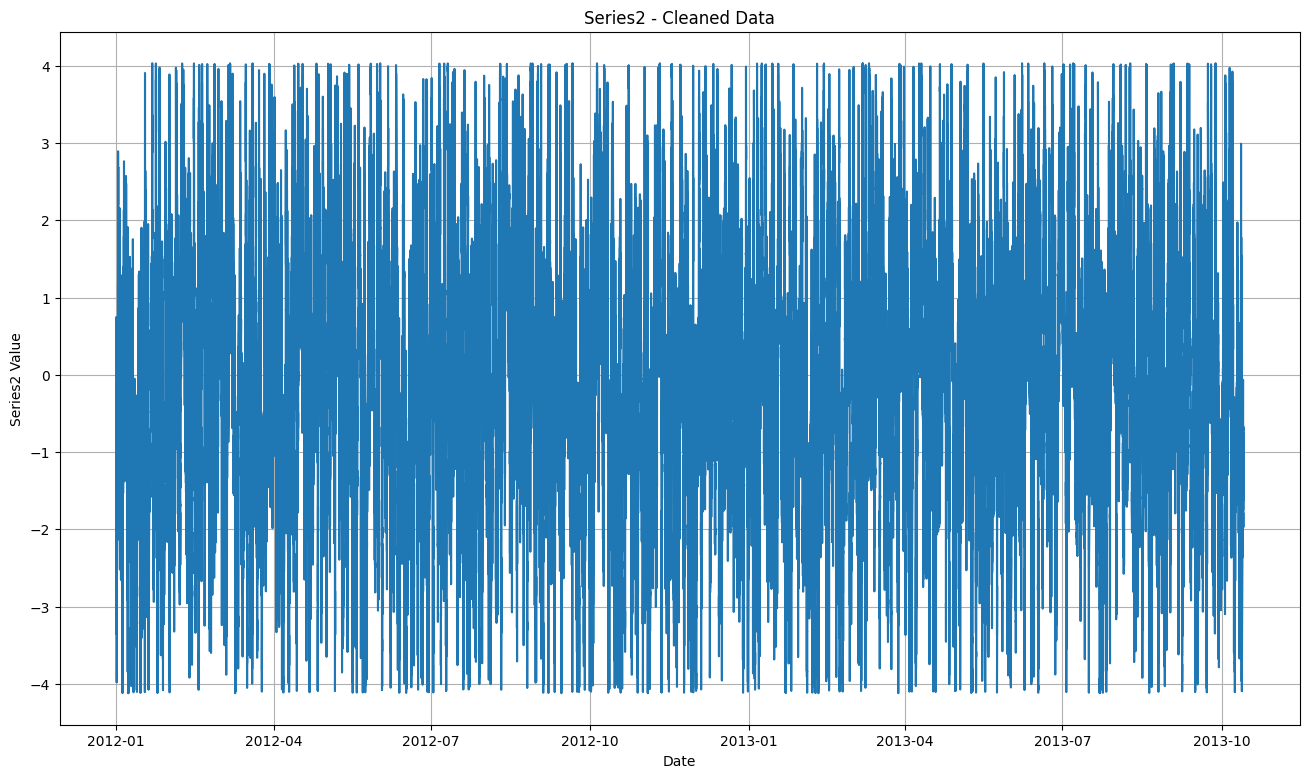

Column: Series3
Outliers removed: 9997
Missing values filled: 55935


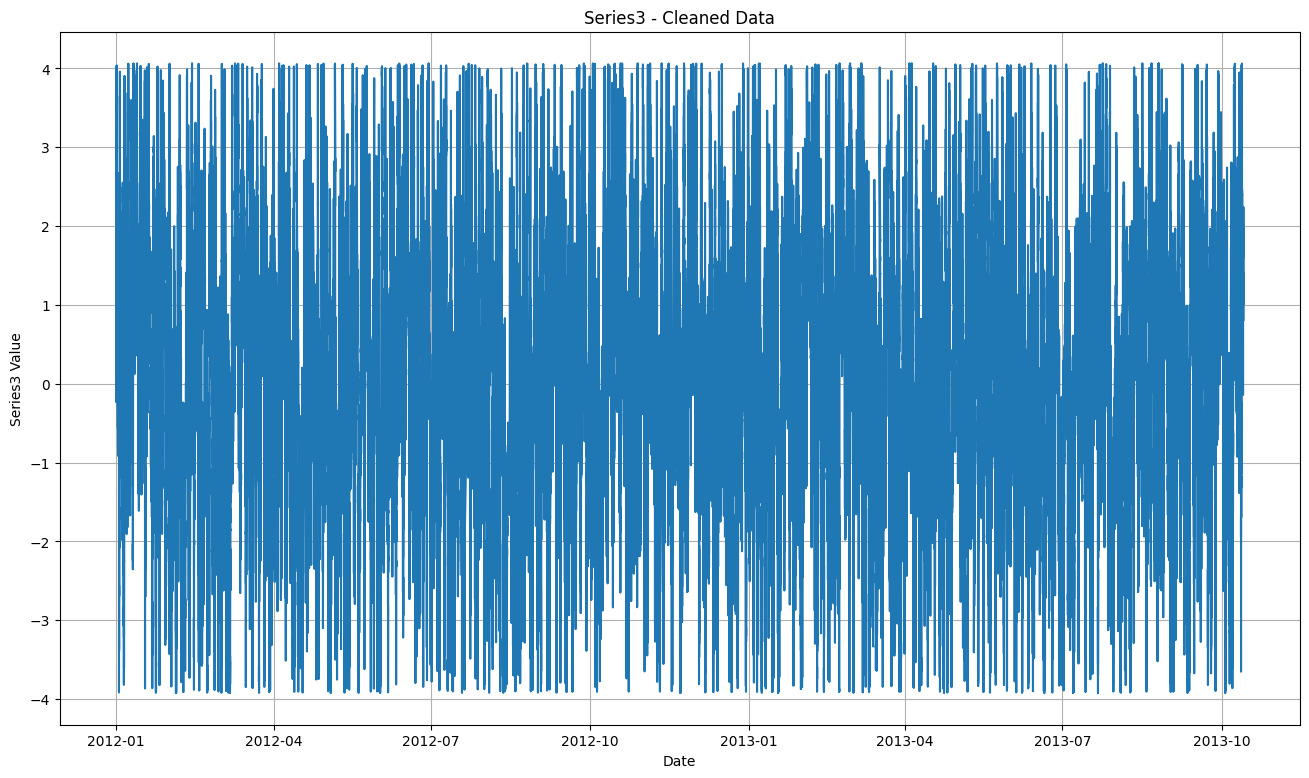

Column: Series4
Outliers removed: 7775
Missing values filled: 53642


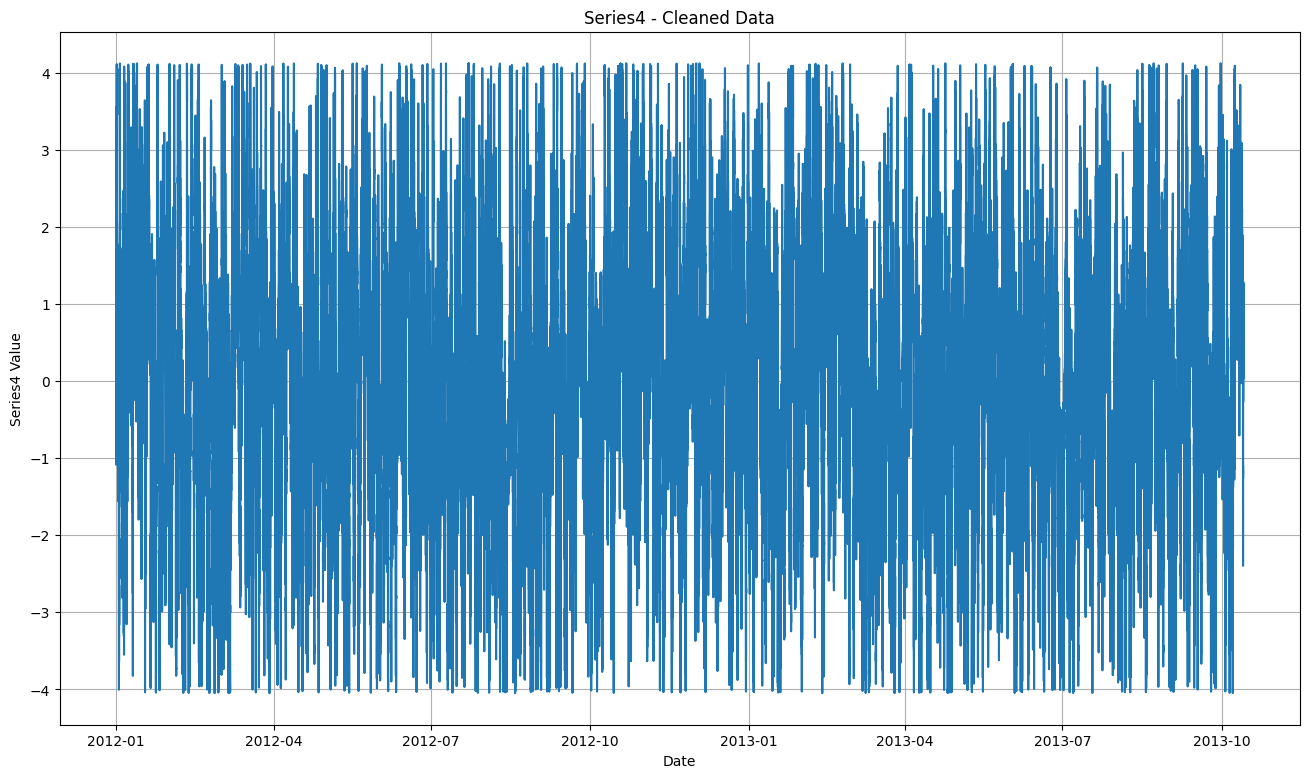

Column: Series5
Outliers removed: 4156
Missing values filled: 49686


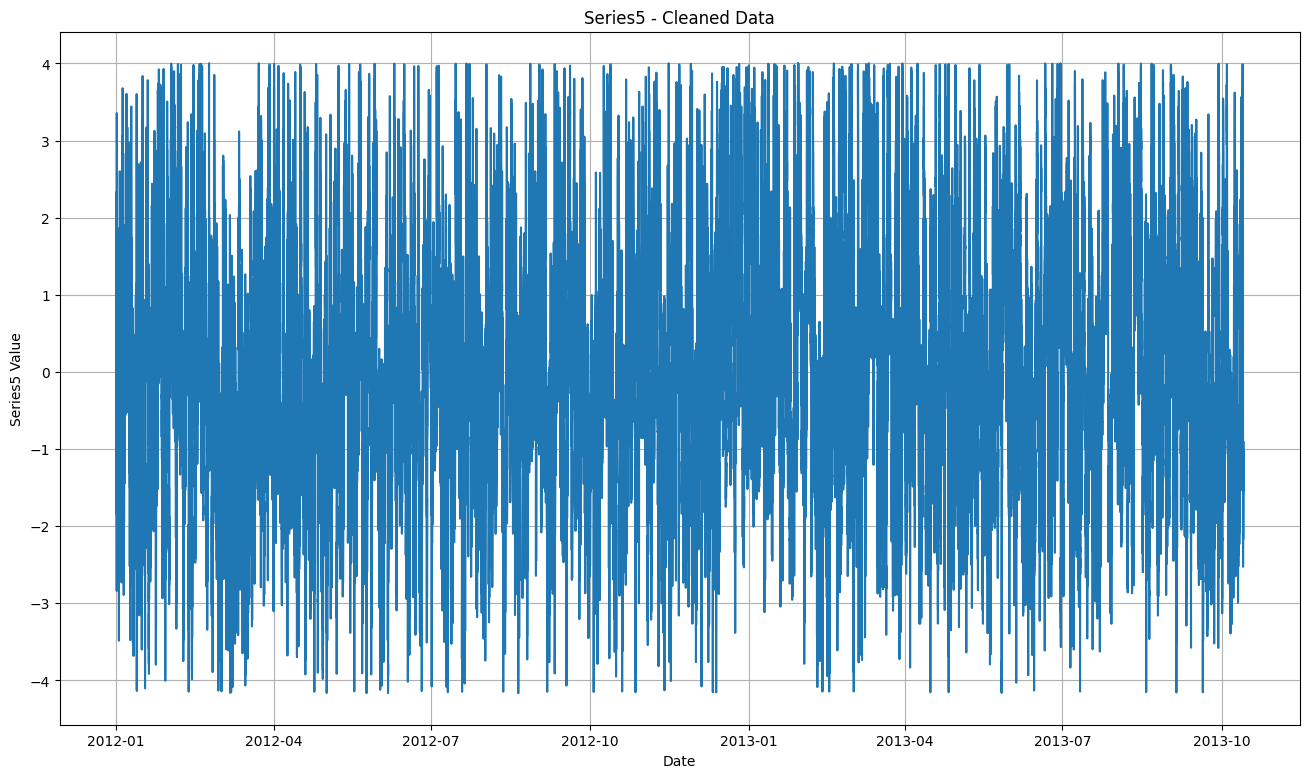

Column: Series6
Outliers removed: 4728
Missing values filled: 50341


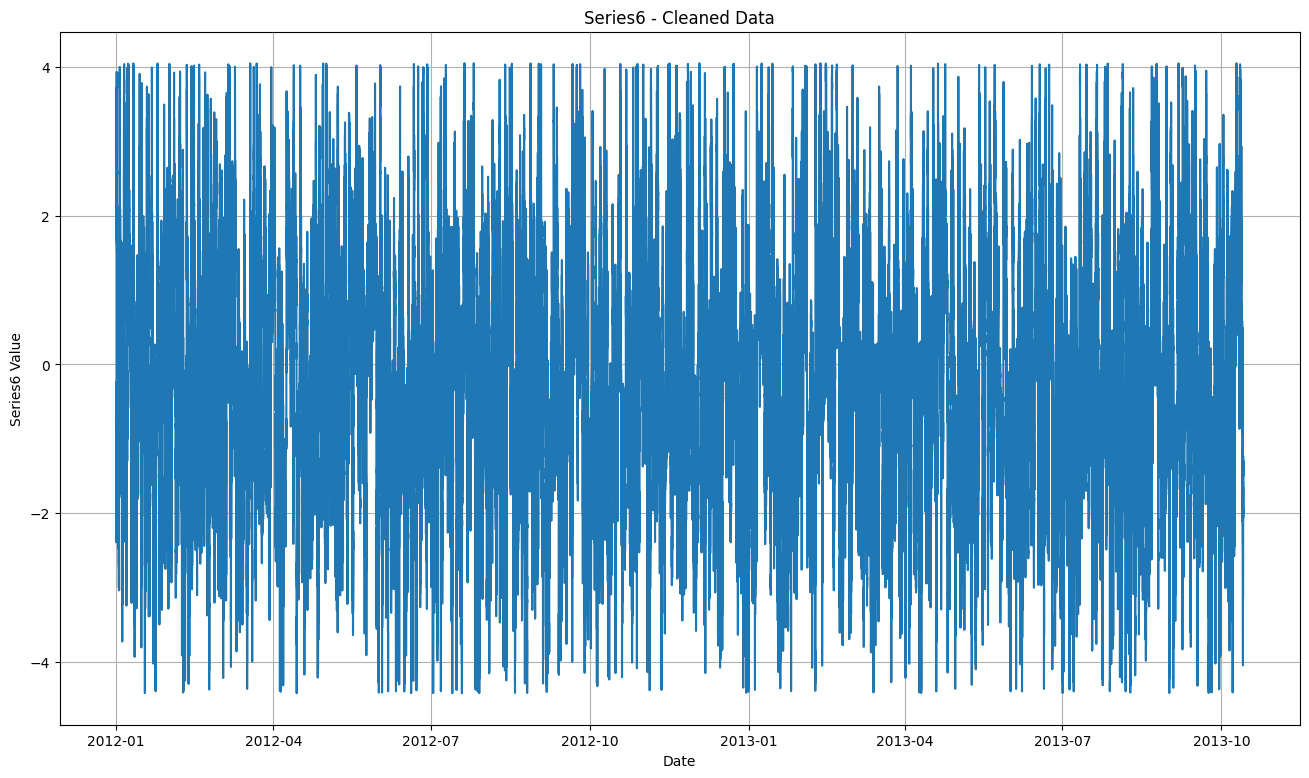

In [3]:
from preprocessing.cleaning import TimeSeriesCleaner


cleaned_df = pd.DataFrame(index=df.index)


# Usage in your loop
for col in df.columns:
    series = df[col]

    series_cleaner = TimeSeriesCleaner(series)

    # Clean series
    cleaned_data = (
        series_cleaner
        .remove_outliers_iqr(multiplier=1.5)  # Remove outliers and replace them with NaN
        .fill_missing(strategy="ffill")  # Fill NaNs with the mean
        .get_df()  # or .get_series()
    )

    outliers_removed, missing_filled = series_cleaner.get_removal_and_fill_stats()

    cleaned_df[col] = cleaned_data.iloc[:, 0]

    print(f"Column: {col}")
    print(f"Outliers removed: {outliers_removed}")
    print(f"Missing values filled: {missing_filled}")

    plt.figure(figsize=(16, 9))
    plt.plot(cleaned_data)
    plt.title(f"{col} - Cleaned Data")
    plt.xlabel("Date")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.show()


cleaned_df.to_csv('../data/processed/cleaned_train_set.csv')

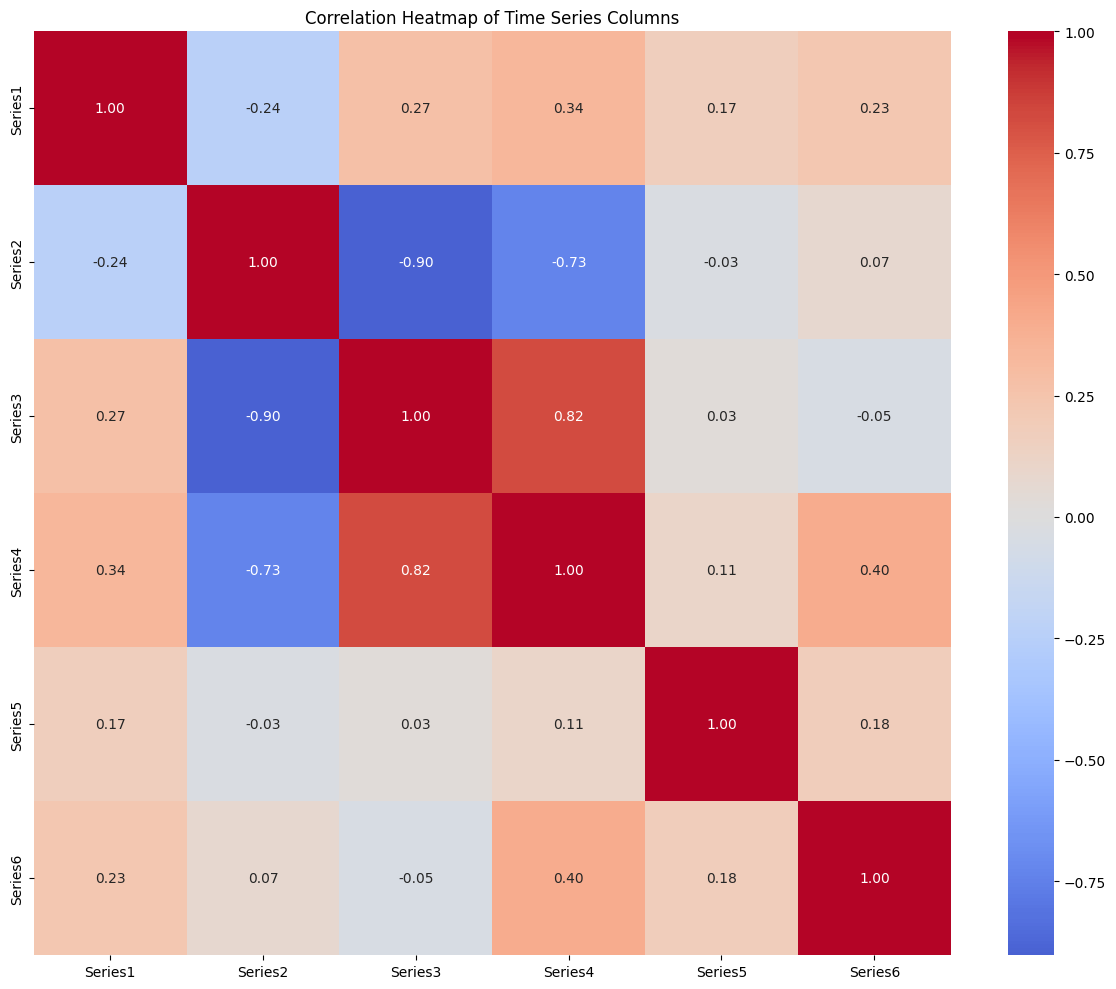

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Time Series Columns")
plt.tight_layout()
plt.show()

Cumulative explained variance:
Component 1: 0.4739
Component 2: 0.7008
Component 3: 0.8409
Component 4: 0.9655
Component 5: 0.9895
Component 6: 1.0000


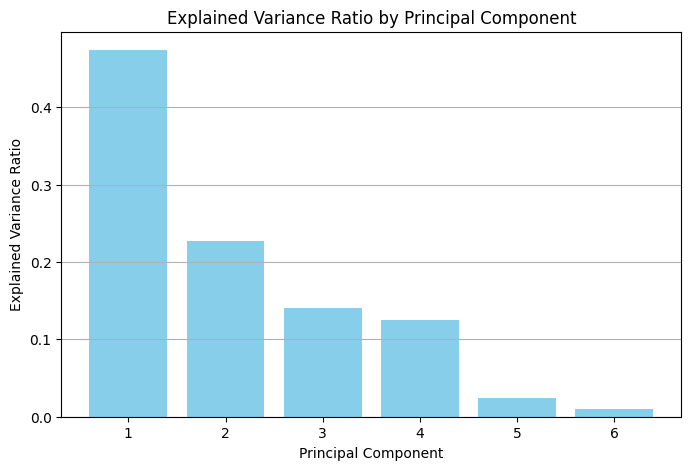

                        pca_0     pca_1     pca_2     pca_3     pca_4  \
Date                                                                    
2012-01-01 00:00:00  2.188047 -1.704329 -0.984776  0.935630  0.138780   
2012-01-01 00:01:00  2.289537 -1.699433 -1.042088  0.845343  0.191572   
2012-01-01 00:02:00  2.375670 -1.753058 -0.977310  0.922319  0.260018   
2012-01-01 00:03:00  2.157599 -1.932353 -0.881856  0.861564  0.217710   
2012-01-01 00:04:00  2.233836 -1.927648 -0.877527  0.882811  0.259967   
...                       ...       ...       ...       ...       ...   
2013-10-13 15:27:00  1.360627 -2.978729 -0.164513  0.145108 -0.148085   
2013-10-13 15:28:00  1.681962 -3.153585 -0.209451 -0.062610 -0.010145   
2013-10-13 15:29:00  1.651270 -3.047671 -0.345764 -0.220496 -0.046922   
2013-10-13 15:30:00  1.512888 -3.003260 -0.306243 -0.133008 -0.158980   
2013-10-13 15:31:00  1.640299 -3.036840 -0.271360 -0.078604 -0.072956   

                        pca_5  
Date              

In [5]:
import pandas as pd
from general.structures import TSdata
from preprocessing.cleaning0 import *

ts = TSdata(data=cleaned_df)

ts.time = 'time'
ts.features = df.columns

# Use PCA Transformer
pca_transformer = PCATransformer(n_components=6)
ts_pca = pca_transformer.fit_transform(ts)

pca_transformer.plot_explained_variance()

print(ts_pca.data)
print("New features:", ts_pca.features)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")  # Optional: suppress convergence warnings

class AutoARIMAMultivariate:
    """
    """

    def __init__(self, order=(10, 10, 10)):
        """
        Initialize the multivariate ARIMA modeler.

        Args:
            order (tuple): ARIMA(p,d,q) order to use for all series.
        """
        self.models = {}
        self.metrics = {}
        self.order = order

    def fit(self, df: pd.DataFrame):
        """
        Fit an ARIMA model for each time series (column).

        Args:
            df (pd.DataFrame): DataFrame with datetime index and series as columns.
        """
        self.columns = df.columns
        for col in self.columns:
            model = ARIMA(df[col], order=self.order)
            fitted_model = model.fit()
            self.models[col] = fitted_model

    def predict(self, periods: int) -> pd.DataFrame:
        """
        Forecast future periods for each series.

        Args:
            periods (int): Number of future steps to predict.

        Returns:
            pd.DataFrame: DataFrame with forecasts.
        """
        forecasts = {}
        for col, model in self.models.items():
            forecasts[col] = model.forecast(steps=periods)
        return pd.DataFrame(forecasts)

    def evaluate(self, df: pd.DataFrame, periods: int):
        """
        Evaluate model performance on the last `periods` observations.

        Args:
            df (pd.DataFrame): Original time series DataFrame.
            periods (int): Number of periods to predict and compare.
        """
        self.metrics = {}
        train = df.iloc[:-periods]
        test = df.iloc[-periods:]

        # Refit models on train set
        self.fit(train)
        preds = self.predict(periods)
        preds.index = test.index  # Align prediction index

        for col in self.columns:
            mse = mean_squared_error(test[col], preds[col])
            mape = mean_absolute_percentage_error(test[col], preds[col])
            self.metrics[col] = {'MSE': mse, 'MAPE': mape}

    def plot_forecasts(self, df: pd.DataFrame, periods: int):
        """
        Plot actual vs predicted values for each series.

        Args:
            df (pd.DataFrame): Original time series DataFrame.
            periods (int): Number of periods to predict and plot.
        """
        train = df.iloc[:-periods]
        test = df.iloc[-periods:]

        # Refit models on train set
        self.fit(train)
        preds = self.predict(periods)
        preds.index = test.index  # Align prediction index

        for col in self.columns:
            plt.figure(figsize=(10, 6))
            plt.plot(train.index, train[col], label='Train', color='blue')
            plt.plot(test.index, test[col], label='Test', color='green')
            plt.plot(preds.index, preds[col], label='Forecast', color='red', linestyle='--')
            plt.title(f'Forecast for {col}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
            plt.tight_layout()  # Adjust layout to avoid overlap
            plt.show()

    def get_metrics(self) -> pd.DataFrame:
        """
        Get the evaluation metrics as a DataFrame.

        Returns:
            pd.DataFrame: Metrics per series.
        """
        return pd.DataFrame(self.metrics).T


🔍 Analyzing column: Series1
ADF Statistic: -2.5202
p-value: 0.1106


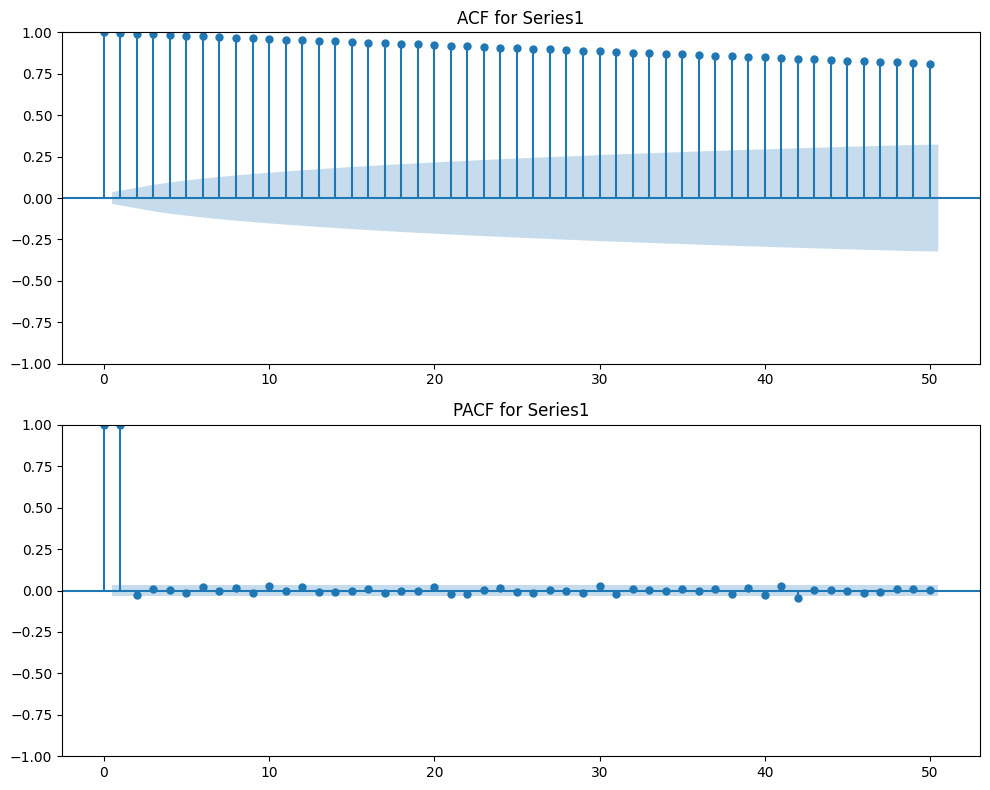

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

def analyze_and_find_best_arima(df: pd.DataFrame, lags: int = 50, max_p: int = 5, max_d: int = 2, max_q: int = 5):
    """
    Analyze stationarity, plot ACF/PACF, and manually grid search best ARIMA(p,d,q) for each column.

    Args:
        df (pd.DataFrame): Time series DataFrame with multiple columns.
        lags (int): Number of lags to display in ACF/PACF plots.
        max_p (int): Maximum p to try.
        max_d (int): Maximum d to try.
        max_q (int): Maximum q to try.
    """
    best_orders = {}

    for col in df.columns:
        print(f"\n🔍 Analyzing column: {col}")
        series = df[col].dropna()

        # 1. ADF Stationarity Test
        result = adfuller(series)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")

        # 2. Plot ACF and PACF
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        plot_acf(series, ax=axes[0], lags=lags)
        axes[0].set_title(f'ACF for {col}')
        plot_pacf(series, ax=axes[1], lags=lags, method='ywm')
        axes[1].set_title(f'PACF for {col}')
        plt.tight_layout()
        plt.show()

        # 3. Full Grid Search over (p,d,q)
        best_aic = float('inf')
        best_order = None

        for d in range(0, max_d + 1):
            for p in range(0, max_p + 1):
                for q in range(0, max_q + 1):
                    try:
                        model = ARIMA(series, order=(p, d, q)).fit()
                        if model.aic < best_aic:
                            best_aic = model.aic
                            best_order = (p, d, q)
                    except:
                        continue

        if best_order:
            print(f"✅ Best ARIMA order for {col}: {best_order} (AIC: {best_aic:.2f})")
            best_orders[col] = best_order
        else:
            print(f"❌ No valid ARIMA model found for {col}")

    return best_orders


analyze_and_find_best_arima(cleaned_df[:3000])

In [ ]:
# model = AutoARIMAMultivariate()

# df = cleaned_df[:3000]
# model.evaluate(df, periods=240)
# model.plot_forecasts(df, periods=240)
# print(model.get_metrics())

KeyboardInterrupt: 